<a href="https://colab.research.google.com/github/afdmoraes/GEOSelper/blob/main/afdmoraes_notebook1_combina%C3%A7%C3%A3o_ndwi_mapa_de_ruas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Curso de Programação para Sensoriamento Remoto
---

* Gilberto Ribeiro de Queiroz
* Thales Sehn Körting

## Combinação de dados vetoriais e matriciais

Neste exemplo, vamos observar uma imagem Sentinel-2 de 18/02/2021 (bandas verde e infra-vermelho combinadas em uma imagem NDWI) da região de Tarauacá, Acre, Brasil, atingida pela cheia do rio Tarauacá em Fevereiro de 2021.

Fonte: https://g1.globo.com/ac/acre/noticia/2021/02/20/com-90percent-da-cidade-atingida-pela-cheia-tarauaca-decreta-calamidade-publica.ghtml

A partir de dados vetoriais do *Open Street Map*, é possível observar algumas ruas da cidade.

A proposta deste exercício é calcular quais segmentos de ruas possuem maiores concentrações de valores de NDWI, o que pode corresponder a partes da cidade afetadas.

## Instalação e carga das bibliotecas necessárias

Para realizar esta atividade, utilizaremos as bibliotecas `rasterstats`, `rasterio`, `geopandas` e `folium`.
* `rasterstats` é um módulo Python para sumarizar dados de imagens baseado em geometrias vetoriais, incluindo estatística zonal e interpolação (https://pythonhosted.org/rasterstats/)
* `rasterio` é uma biblioteca criada para abstrair os dados raster em formato compatível com a biblioteca padrão Python (https://rasterio.readthedocs.io/)
* `geopandas` dá suporte a objetos geográficos e permite realizar a leitura e escrita de dados vetoriais (https://geopandas.org/)
* `folium` facilita a visualização de dados geográficos em mapas (https://python-visualization.github.io/folium/)

In [2]:
# instalação das bibliotecas rasterstats, rasterio, geopandas
!pip install rasterstats
!pip install rasterio==1.1.8
!pip install --upgrade geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 139 kB 8.0 MB/s 
     |████████████████████████████████| 20.9 MB 7.6 MB/s 
     |████████████████████████████████| 16.6 MB 56.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.2 MB 1.7 MB/s 
  Attempting uninstall: rasterio
    Found existing installation: rasterio 1.3.4
    Uninstalling rasterio-1.3.4:
      Successfully uninstalled rasterio-1.3.4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.2 MB/s 
     |████████████████████████████████| 7.8 MB 52.3 MB/s 


In [3]:
# importação das bibliotecas necessárias
from rasterstats import zonal_stats
import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import geopandas as gpd
import folium
from matplotlib import cm

## Carregar os dados

É preciso fazer o upload dos arquivos na sua área:
* `ndwi_sentinel_reprojected.tif` contendo a imagem NDWI
* `streets.shp`, `streets.prj`, `streets.dbf` e `streets.shx` contendo as geometrias

In [4]:
# abrir a imagem NDWI com a mesma projeção 
# dos vetores de ruas
reprojected_raster = rio.open('ndwi_sentinel_reprojected.tif')
ndwi = reprojected_raster.read()[0].astype(float)

# abrir as geometrias
streets = gpd.read_file('streets.shp', encoding='utf-8')

## Usando a *rasterstats*, é possível calcular a estatística zonal

In [6]:
# calcular estatísticas de cada segmento
# das ruas, com base nos maiores NDWI's
# presentes (por issso stats="max")
stats = zonal_stats(streets, 
                    ndwi, 
                    stats="max", 
                    affine=reprojected_raster.transform)

# criar um GeoPandas combinando as informações
# necessárias (geometrias e estatísticas)
data_sum = {
    'geometry': streets.geometry,
    'name': streets.name,
    'statistics': [f['max'] for f in stats],}
streets_statistics = gpd.GeoDataFrame(data=data_sum)

# apresentar as estatísticas da métrica 'max'
# para auxiliar na definição de um limiar
streets_statistics.describe()

/usr/local/lib/python3.8/dist-packages/rasterstats/main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
/usr/local/lib/python3.8/dist-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


,statistics
count,276.000000
mean,-0.100503
std,0.134713
min,-0.467099
25%,-0.207904
50%,-0.092952
75%,0.017101
max,0.201248


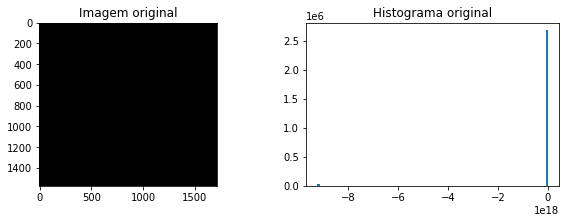

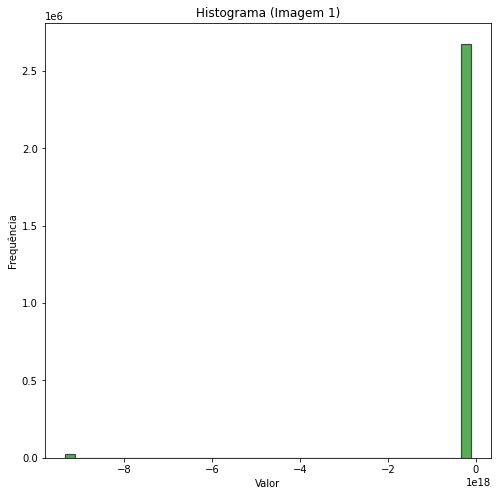

In [29]:
# USANDO O SCRIPT EXEMPLO 
# importar a biblioteca gdal e a matplotlib
from osgeo import gdal
import matplotlib.pyplot as plt

# informar o uso de excecoes
gdal.UseExceptions()

# Abrir a primeira imagem (1)
dataset = gdal.Open('ndwi_sentinel_reprojected.tif', gdal.GA_ReadOnly)

# obter a banda (neste caso a imagem só tem 1 banda)  (1)
banda = dataset.GetRasterBand(1)

# obter a matriz de pixels da banda  (1)
matriz = banda.ReadAsArray().astype(int)

# plotar a imagem e o histograma (1)
plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.imshow(matriz, cmap='gray', vmin=0, vmax=255)
plt.title('Imagem original');
plt.subplot(122)
plt.hist(matriz.flatten(), bins=100)
plt.title('Histograma original');

# (a) abra as 2 imagens utilizando a GDAL, e gere uma visualização de cada imagem e de seu histograma

# Vamos considerar o seguinte exemplo extraído da galeria da Matplotlib e do site da NumPy: Gerando Histrograma
values = matriz.flatten()

plt.figure( figsize=(8, 8) )
plt.hist(values, bins=40, density=False, align='left',
         facecolor='green', edgecolor='black', linewidth=1.2, alpha=0.65);
       
plt.title(r"Histograma (Imagem 1)")
plt.xlabel("Valor")
plt.ylabel("Frequência");


## Calculando as ruas com valores máximos de NDWI acima de um limiar

In [8]:
# podemos definir um limiar acima do qual o valor 
# máximo de NDWI pode representar uma área
# afetada pela cheia
affected_threshold = 0.017101
affected_streets = streets_statistics[streets_statistics.statistics > affected_threshold]

# para visualizar as geometrias num mapa base (basemap)
# vamos converter os dados para o formato conhecido
# pela biblioteca folium
streets_json = streets.to_crs(epsg='4326').to_json()
affected_streets_json = affected_streets.to_crs(epsg='4326').to_json()
affected_streets_geojson = folium.features.GeoJson(affected_streets_json)

# obter as coordenadas dos cantos da imagem
# para centralizar a visualização no mapa
north = reprojected_raster.bounds.top
south = reprojected_raster.bounds.bottom
east = reprojected_raster.bounds.right
west = reprojected_raster.bounds.left

## Visualizando a imagem NDWI, o mapa de ruas, e as ruas afetadas


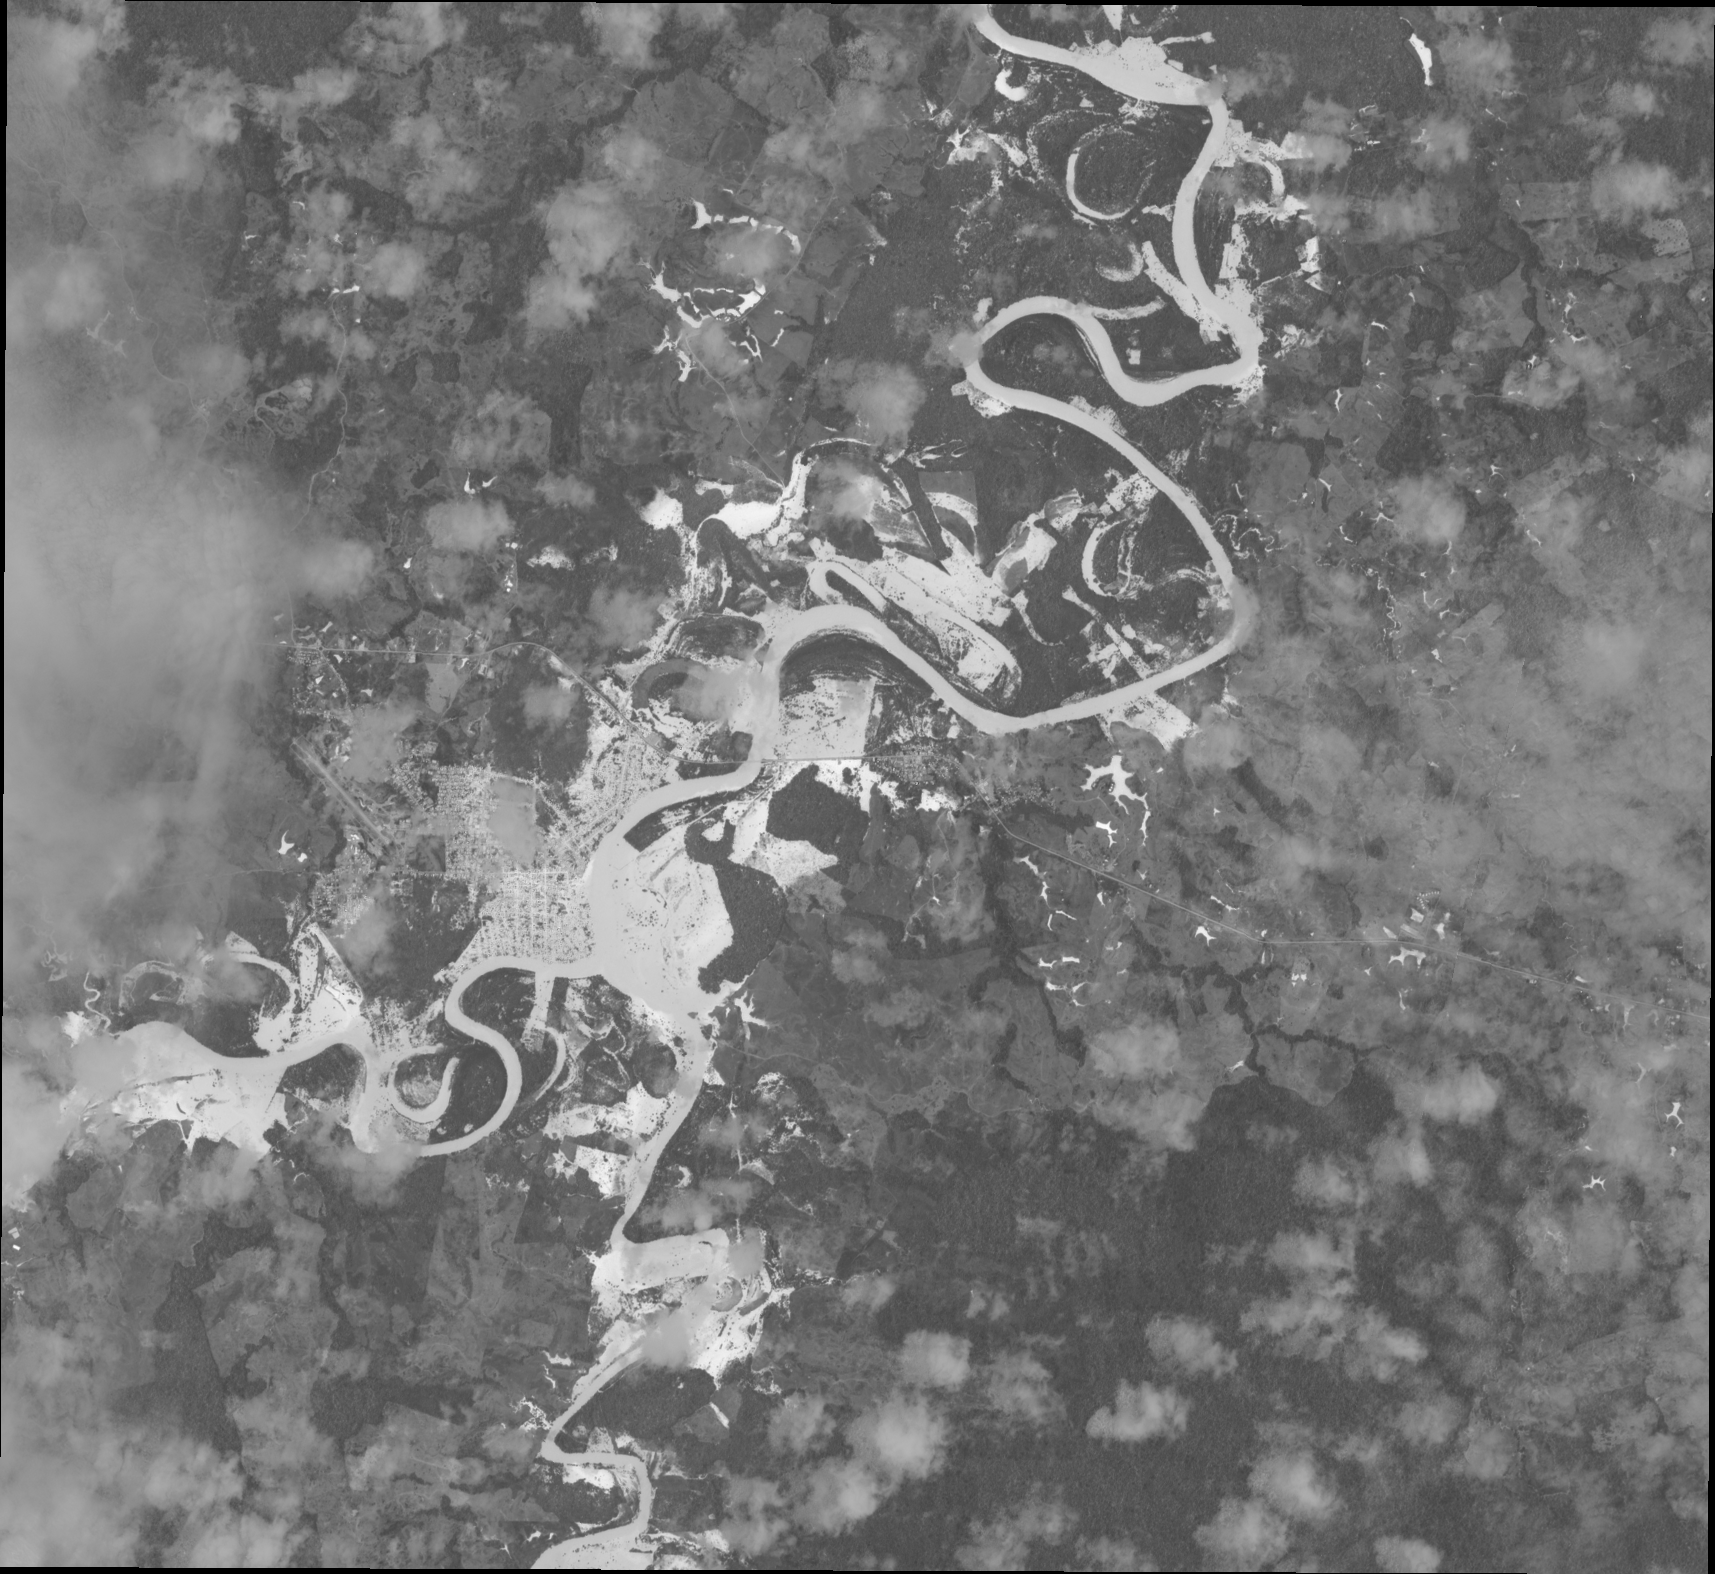

In [30]:
# vamos alterar o intervalo de valores da imagem
# apenas para visualizar, pois é desta maneira
# que o folium trabalha
# a imagem NDWI, com intervalo original entre -1 e +1
# podemos alterar o intervalo para [0, 254], somando
# os valores com +1, e esse resultado multiplicamos
# por 127
ndwi_folium = 127 * (ndwi + 1)

# podemos criar uma visualização de um mapa
# (basemap) através da biblioteca folium
# centralizado de acordo com a imagem NDWI
m = folium.Map(location=[(north + south)/2, (east + west)/2], 
               zoom_start=13,
               tiles='CartoDB Positron')

# adicionar uma visualização da imagem NDWI
folium.raster_layers.ImageOverlay(ndwi_folium, 
                                  opacity=.7, 
                                  bounds=[[north, east], [south, west]],
                                  name="NDWI").add_to(m)

# adicionar o mapa de ruas na cor azul e as
# ruas afetadas na cor verde
folium.GeoJson(streets_json, name="Todas as ruas", 
               style_function = lambda x: {'color': 'blue', 'width': 0.5}).add_to(m)
folium.GeoJson(affected_streets_json, name="Ruas afetadas", 
               style_function = lambda x: {'color': 'green', 'width': 0.5}).add_to(m)

# permitir a escolha de camadas (layers) 
folium.LayerControl().add_to(m)

# visualizar o mapa
m

# Conclusão

Este `colab` é uma sugestão de aplicações envolvendo a manipulação conjunta de dados matriciais e vetoriais. Podemos gerar o NDWI a partir da abertura das bandas de uma imagem e realização de aritmética de bandas por meio da biblioteca `numpy`. 

Abrimos as geometrias e fizemos seleção de feições de acordo com propriedades calculadas. Esses cálculos foram realizados a partir da biblioteca `rasterstats` e a manipulação das geometrias foi feita com a biblioteca `geopandas`.

Por fim, exploramos de maneira breve a biblioteca `folium`, capaz de exibir mapas base (*base maps*) e incluir imagens e geometrias em forma de camadas.